In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

### INITIER LES DOSSIERS DE TEST ET D'ENTRAINEMENT

In [2]:
 TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [3]:
def createDataFrame(dir):
    labels = []
    image_paths = []
    for label in os.listdir(dir):
        for imageName in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir, label, imageName))
            labels.append(label)
            print(labels,"completed")
    return image_paths, labels

### CREATION DATASET

In [4]:
train = pd.DataFrame()
train['image'], train['labels'] = createDataFrame(TRAIN_DIR)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
test = pd.DataFrame()
test['image'], test['labels'] = createDataFrame(TEST_DIR)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
print(test)

                              image    labels
0       images/test\angry\10052.jpg     angry
1       images/test\angry\10065.jpg     angry
2       images/test\angry\10079.jpg     angry
3       images/test\angry\10095.jpg     angry
4       images/test\angry\10121.jpg     angry
...                             ...       ...
7061  images/test\surprise\9806.jpg  surprise
7062  images/test\surprise\9830.jpg  surprise
7063  images/test\surprise\9853.jpg  surprise
7064  images/test\surprise\9878.jpg  surprise
7065   images/test\surprise\993.jpg  surprise

[7066 rows x 2 columns]


In [ ]:
print(train)

### EXTRACTION DE TOUS LES VARIABLES INDEPENDANTES

In [8]:
from tqdm.notebook  import tqdm

In [9]:
def extractFeatures(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [10]:
train_features = extractFeatures(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

C:\Users\HP G5\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [11]:
test_features = extractFeatures(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

### TOUJOURS LES FAIRES EN FLOAT

In [12]:
x_train = train_features/255.0
x_test = test_features/255.0

### PREPROCESSING

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()
le.fit(train['labels'])

LabelEncoder()

In [15]:
y_train = le.transform(train['labels'])
y_test = le.transform(test['labels'])

In [16]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

### CREATION DES LAYERS DU RESEAU DES NEURONNES( LES HIDDEN LAYERS ET FULLY CONNECTED LAYERS)/ ICI ON UTILISE L'API SEQUENTIEL DE KERAS 

In [17]:
from keras.layers import Dropout

In [18]:
model = keras.Sequential()
#Conv 2D layers
model.add(Conv2D(128,kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
#layers connecté
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#final output
model.add(Dense(7, activation='softmax'))

In [19]:
model.compile (
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss ='categorical_crossentropy',
                    metrics='accuracy',
                )
model.fit(x = x_train, y = y_train, batch_size=128, epochs=5 , validation_data = (x_test, y_test))

Epoch 1/5
226/226 [==============================] - 704s 3s/step - loss: 1.8060 - accuracy: 0.2477 - val_loss: 1.7037 - val_accuracy: 0.3038
Epoch 2/5
226/226 [==============================] - 689s 3s/step - loss: 1.6176 - accuracy: 0.3597 - val_loss: 1.4776 - val_accuracy: 0.4339
Epoch 3/5
226/226 [==============================] - 692s 3s/step - loss: 1.4659 - accuracy: 0.4325 - val_loss: 1.3515 - val_accuracy: 0.4846
Epoch 4/5
226/226 [==============================] - 687s 3s/step - loss: 1.3787 - accuracy: 0.4689 - val_loss: 1.2880 - val_accuracy: 0.5144
Epoch 5/5
226/226 [==============================] - 689s 3s/step - loss: 1.3205 - accuracy: 0.4937 - val_loss: 1.2202 - val_accuracy: 0.5393


In [20]:
model_json = model.to_json()
with open('emotiondetector.json','w') as json_file:
    json_file.write(model_json)
model.save('emotiondetector.h5')

C:\Users\HP G5\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from keras.models import model_from_json

In [23]:
json_file = open("facialemotionmodel.json","r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("facialemotionmodel.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'facialemotionmodel.json'

In [44]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [45]:
def ef(image):
    features = []
    img = load_img(image,grayscale = True)
    img = np.array(img)
    features.append(img)
    features = np.array(features)
    features.reshape(len(features),48,48,1)
    return features/255.0

In [46]:
image = 'images/train/angry/22.jpg'
print("original image is angry ....")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is", pred_label)

original image is angry ....
1/1 [==============================] - 3s 3s/step
model prediction is angry


In [47]:
image = 'images/train/sad/42.jpg'
print("original image is angry ....")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is", pred_label)

original image is angry ....
1/1 [==============================] - 0s 97ms/step
model prediction is sad


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is angry ....
1/1 [==============================] - 0s 40ms/step
model prediction is sad


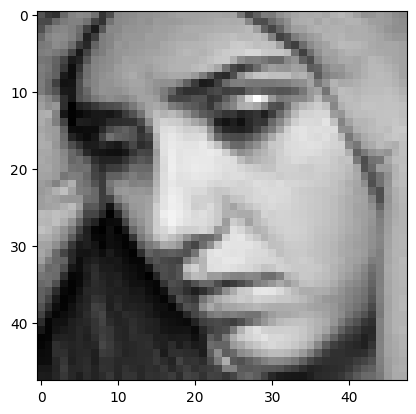

In [62]:
image = 'images/test/sad/231.jpg'
print("original image is angry ....")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is", pred_label)
plt.imshow(img.reshape(48,48), cmap='gray')

In [64]:
model.evaluate(x = x_test, y = y_test, batch_size=32, verbose = 2)

221/221 - 32s - loss: 1.2202 - accuracy: 0.5393 - 32s/epoch - 146ms/step


[1.2201662063598633, 0.5393433570861816]

### TEST SUR L'API SUBCLASSING DE KERAS => BLOCAGES RESSOURCES MACHINES solutions: AZURES ET GOOGLE COLABS

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, Flatten, Dense
from tensorflow.keras.models import Model

def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape=(224, 224, 3), classes=1000):
    X_input = Input(input_shape)
    
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model
